# Time Series Forecasting

In this tutorial, we will use `numpyro` to do forecasting. Specifically, we will replicate the **Seasonal, Global Trend (SGT)** model in [Rlgt: Bayesian Exponential Smoothing Models with Trend Modifications](https://cran.r-project.org/web/packages/Rlgt/index.html) package. Data is the famous **lynx** time series, which contains annual numbers of lynx trappings from 1821 to 1934 in Canada.

In [1]:
import os
if os.cpu_count() >= 4:
    # set this XLA flags to run 4 chains MCMC in parallel
    os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as np
from jax import lax, random, vmap
from jax.config import config; config.update("jax_platform_name", "cpu")

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.distributions.util import softmax
from numpyro import handlers
from numpyro.mcmc import MCMC, NUTS

## Data

First, let's import and take a look at the dataset.

Length of time series: 114


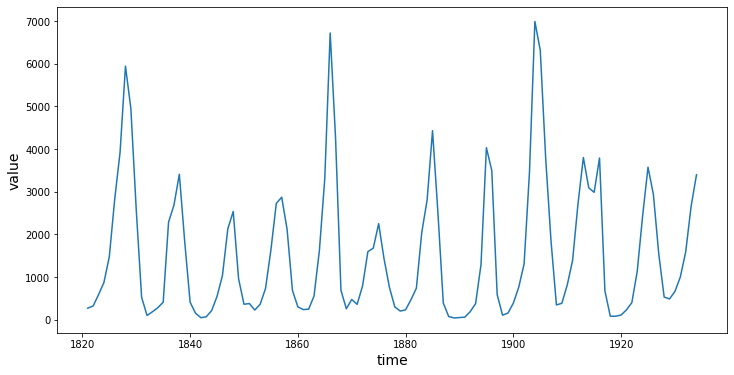

In [2]:
URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv"
lynx = pd.read_csv(URL, index_col=0)
data = lynx["value"].values
print("Length of time series:", data.shape[0])
plt.figure(figsize=(12, 6))
plt.plot(lynx["time"], data)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.show()

The time series has a length of 114 (a data point for each year), and by looking at the plot, we can observe [seasonality](https://en.wikipedia.org/wiki/Seasonality) in this dataset, which is the recurrence of similar patterns at specific time periods. e.g. in this dataset, we observe a cyclical pattern every 10 years, but there is also a less obvious but clear spike in the number of trappings every 40 years. Let us see if we can model this effect in NumPyro.

In this tutorial, we will use the first 80 values for training and the last 34 values for testing.

In [3]:
y_train, y_test = np.array(data[:80], dtype=np.float32), data[80:]

## Model

The model we are going to use is called **Seasonal, Global Trend**, which when tested on 3003 time series of the [M-3 competition](https://forecasters.org/resources/time-series-data/m3-competition/), has been known to outperform other models originally participating in the competition:

\begin{equation*}
\begin{gathered}
\text{exp_val}_{t} = \text{level}_{t-1} + \text{coef_trend} \times \text{level}_{t-1}^{\text{pow_trend}} + \text{s}_t \times \text{level}_{t-1}^{\text{pow_season}}, \\
\sigma_{t} = \sigma \times \text{exp_val}_{t}^{\text{powx}} + \text{offset}, \\
y_{t} \sim \text{StudentT}(\nu, \text{exp_val}_{t}, \sigma_{t}),
\end{gathered}
\end{equation*}

where `level` and `s` follows the following recursion rules:

\begin{equation*}
\begin{gathered}
\text{level_p} =
\begin{cases}
y_t - \text{s}_t \times \text{level}_{t-1}^{\text{pow_season}} & \text{if } t \le \text{seasonality}, \\ 
\text{Average} \left[y(t - \text{seasonality} + 1), \ldots, y(t)\right] & \text{otherwise},
\end{cases} \\
\text{level}_{t} = \text{level_sm} \times \text{level_p} + (1 - \text{level_sm}) \times \text{level}_{t-1}, \\
\text{s}_{t + \text{seasonality}} = \text{s_sm} \times \frac{y_{t} - \text{level}_{t}}{\text{level}_{t-1}^{\text{pow_trend}}}
+ (1 - \text{s_sm}) \times \text{s}_{t}.
\end{gathered}
\end{equation*}

A more detailed explanation for SGT model can be found in [this vignette](https://cran.r-project.org/web/packages/Rlgt/vignettes/GT_models.html) from the authors of Rlgt package. Here we summarize the core ideas of this model:

+ [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), which has heavier tails than normal distribution, is used for the likelihood.
+ The expected value `exp_val` consists of a trending component and a seasonal component:
  - The trend is governed by the map $x \mapsto x + ax^b$, where $x$ is `level`, $a$ is `coef_trend`, and $b$ is `pow_trend`. Note that when $b \sim 0$, the trend is linear with $a$ is the slope, and when $b \sim 1$, the trend is exponential with $a$ is the rate. So that function can cover a large family of trend.
  - When time changes, `level` and `s` are updated to new values. Coefficients `level_sm` and `s_sm` are used to make the transition smoothly.
+ When `powx` is near $0$, the error $\sigma_t$ will be nearly constant while when `powx` is near $1$, the error will be propotional to the expected value.
+ There are several varieties of SGT. In this tutorial, we use generalized seasonality and seasonal average method.

Note that `level` and `s` are updated recursively while we collect the expected value at each time step. NumPyro uses [JAX](https://github.com/google/jax) in the backend to JIT compile many critical parts of the NUTS algorithm, including the verlet integrator and the tree building process. However, doing so using Python's `for` loop in the model will result in a long compilation time for the model, so we use `jax.lax.scan` instead. A detailed explanation for using this utility can be found in [lax.scan documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html#jax.lax.scan). Here we use it to collect expected values while the pair `(level, s)` plays the role of carrying state.

In [4]:
def scan_exp_val(y, init_s, level_sm, s_sm, coef_trend, pow_trend, pow_season):
    seasonality = init_s.shape[0]

    def scan_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level ** pow_season
        exp_val = level + coef_trend * level ** pow_trend + season
        exp_val = np.clip(exp_val, a_min=0)

        moving_sum = moving_sum + y[t] - np.where(t >= seasonality, y[t - seasonality], 0.)
        level_p = np.where(t >= seasonality, moving_sum / seasonality, y[t] - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = np.clip(level, a_min=0)
        new_s = (s_sm * (y[t] - level) / season + (1 - s_sm)) * s[0]
        s = np.concatenate([s[1:], new_s[None]], axis=0)
        return (level, s, moving_sum), exp_val

    level_init = y[0]
    s_init = np.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    (last_level, last_s, moving_sum), exp_vals = lax.scan(
        scan_fn, (level_init, s_init, moving_sum), np.arange(1, y.shape[0]))
    return exp_vals, last_level, last_s

With our utility function defined above, we are ready to specify the model using *NumPyro* primitives. In NumPyro, we use the primitive `sample(name, prior)` to declare a latent random variable with a corresponding `prior`. These primitives can have custom interpretations depending on the effect handlers that are used by NumPyro inference algorithms in the backend. e.g. we can condition on specific values using the `substitute` handler, or record values at these sample sites in the execution trace using the `trace` handler. Note that these details are not important for specifying the model, or running inference, but curious readers are encouraged to read the [tutorial on effect handlers](http://pyro.ai/examples/effect_handlers.html) in Pyro.

In [5]:
def sgt(y, seasonality):
    # heuristically, standard derivation of Cauchy prior depends on the max value of data
    cauchy_sd = np.max(y) / 150

    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample("offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10,
                                                                       scale=cauchy_sd))

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    exp_val, last_level, last_s = scan_exp_val(
        y, init_s, level_sm, s_sm, coef_trend, pow_trend, pow_season)
    omega = sigma * exp_val ** powx + offset_sigma
    numpyro.sample("y", dist.StudentT(nu, exp_val, omega), obs=y[1:])
    # we return last `level` and last `s` for forecasting
    return last_level, last_s

Note that all prior parameters are retrieved from [this file](https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R) in the original source.

## Inference

First, we want to choose a good value for `seasonality`. Following [the demo in Rlgt](https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/demo/lynx.R), we will set `seasonality=38`. Indeed, this value can be guessed by looking at the plot of the training data, where the second order seasonality effect has a periodicity around $40$ years. Note that $38$ is also one of the highest-autocorrelation lags.

In [6]:
print("Lag values sorted according to their autocorrelation values:\n") 
print(np.argsort(autocorrelation(y_train))[::-1])

Lag values sorted according to their autocorrelation values:

[ 0 67 57 38 68  1 29 58 37 56 28 10 19 39 66 78 47 77  9 79 48 76 30 18
 20 11 46 59 69 27 55 36  2  8 40 49 17 21 75 12 65 45 31 26  7 54 35 41
 50  3 22 60 70 16 44 13  6 25 74 53 42 32 23 43 51  4 15 14 34 24  5 52
 73 64 33 71 72 61 63 62]


Now, let us run $4$ MCMC chains (using the No-U-Turn Sampler algorithm) with $5000$ warmup steps and $5000$ sampling steps per each chain. The returned value will be a collection of $20000$ samples.

In [7]:
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=4)
mcmc.run(random.PRNGKey(2), y_train, seasonality=38)
mcmc.print_summary()
samples = mcmc.get_samples()



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     29.09     98.71     14.56    -91.73    145.81   4051.37      1.00
       init_s[0]     86.54    109.55     64.85    -66.83    238.14   5079.81      1.00
       init_s[1]    -19.97     71.69    -24.72   -131.59     89.60   6249.38      1.00
       init_s[2]     30.63     93.27     18.78   -115.05    170.77   6732.45      1.00
       init_s[3]    124.67    125.71    105.77    -61.38    313.86   8220.25      1.00
       init_s[4]    450.26    256.86    404.19     69.92    811.27   4448.72      1.00
       init_s[5]   1173.79    472.57   1098.92    488.84   1859.04   3314.14      1.00
       init_s[6]   2000.90    676.77   1901.23    945.56   2968.26   2475.09      1.00
       init_s[7]   3668.02   1094.74   3522.61   1922.71   5355.88   2290.69      1.00
       init_s[8]   2615.66    853.63   2500.75   1318.56   3872.21   2247.70      1.00
       init_s[9]    960.49    449.32    8

## Forecasting

Given `samples` from `mcmc`, we want to do forecasting for the testing dataset `y_test`. First, we will make some utilities to do forecasting given a sample. Note that to retrieve the last `level` and last `s` value, we substitute a sample to the model:
```python
...    level, s = substitute(sgt, asample)(y, seasonality)
```

In [8]:
# Ref: https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/forecast.rlgtfit.R
def sgt_forecast(future, asample, y, level, s):
    seasonality = s.shape[0]
    moving_sum = np.sum(y[-seasonality:])
    pow_trend = 1.5 * asample["pow_trend_beta"] - 0.5
    yfs = [0] * (seasonality + future)
    for t in range(future):
        season = s[0] * level ** asample["pow_season"]
        exp_val = level + asample["coef_trend"] * level ** pow_trend + season
        exp_val = np.clip(exp_val, a_min=0)
        omega = asample["sigma"] * exp_val ** asample["powx"] + asample["offset_sigma"]
        yf = numpyro.sample("yf[{}]".format(t), dist.StudentT(asample["nu"], exp_val, omega))
        yf = np.clip(yf, a_min=1e-30)
        yfs[t] = yf

        moving_sum = moving_sum + yf - np.where(t >= seasonality,
                                                yfs[t - seasonality], y[-seasonality + t])
        level_p = moving_sum / seasonality
        level_tmp = asample["level_sm"] * level_p + (1 - asample["level_sm"]) * level
        level = np.where(level_tmp > 1e-30, level_tmp, level)
        # s is repeated instead of being updated
        s = np.concatenate([s[1:], s[:1]], axis=0)


def forecast(future, rng, asample, y, seasonality):
    level, s = handlers.substitute(sgt, asample)(y, seasonality)
    forecast_model = handlers.seed(sgt_forecast, rng)
    forecast_trace = handlers.trace(forecast_model).get_trace(future, asample, y, level, s)
    results = [np.clip(forecast_trace["yf[{}]".format(t)]["value"], a_min=1e-30)
               for t in range(future)]
    return np.stack(results, axis=0)

Then, we can use [jax.vmap](https://jax.readthedocs.io/en/latest/jax.html#jax.vmap) to get prediction given a collection of samples. This allows us to vectorize the computation across the test dataset which can be dramatically faster as compared to using for-loop to collect predictions per test data point.

In [9]:
rngs = random.split(random.PRNGKey(3), samples["nu"].shape[0])
forecast_marginal = vmap(lambda rng, asample: forecast(
    len(y_test), rng, asample, y_train, seasonality=38))(rngs, samples)

Finally, let's get sMAPE, root mean square error of the prediction, and visualize the result with the mean prediction and the 89% highest posterior density interval (HPDI).

In [10]:
y_pred = np.mean(forecast_marginal, axis=0)
sMAPE = np.mean(np.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = np.sqrt(np.mean((y_pred - y_test) ** 2))
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

sMAPE: 62.73, rmse: 1243.96


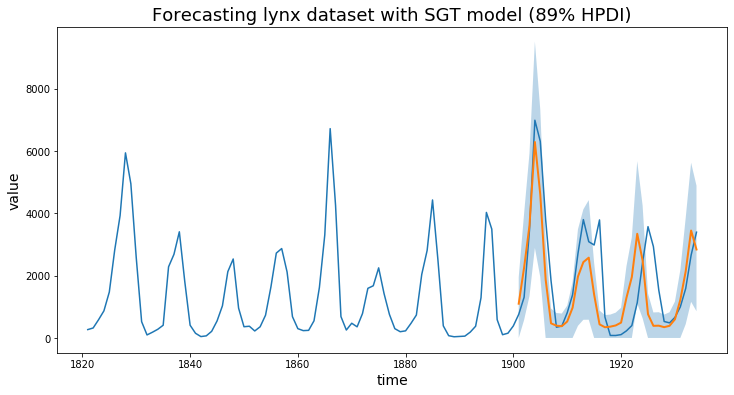

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(lynx["time"], data)
t_future = lynx["time"][80:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting lynx dataset with SGT model (89% HPDI)", fontsize=18)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.show()

As we can observe, the model has been able to learn both the first and second order seasonality effects, i.e. a cyclical pattern with a periodicity of around 10, as well as spikes that can be seen once every 40 or so years. Moreover, we not only have point estimates for the forecast but can also use the uncertainty estimates from the model to bound our forecasts. 

## Acknowledgements

We would like to thank Slawek Smyl for many helpful resources and suggestions. Fast inference would not have been possible without the support of JAX and the XLA teams, so we would like to thank them for providing such a great open-source platform for us to build on, and for their responsiveness in dealing with our feature requests and bug reports.

## References

[1] `Rlgt: Bayesian Exponential Smoothing Models with Trend Modifications`,<br>&nbsp;&nbsp;&nbsp;&nbsp;
Slawek Smyl, Christoph Bergmeir, Erwin Wibowo, To Wang Ng, Trustees of Columbia University